# Лабораторная работа №1

Я выбрал для работы научные публикации связанные с темой **Gambling**

## Выгрузка данных

In [9]:
import requests
import xml.etree.ElementTree as ET
import json
import os
import time

API = "http://export.arxiv.org/api/query"
THEME = "gambling"
OUTPUT_FILE = "gambling_data.json"
MAX_DATA_SIZE = 500

def get_gambling_data_xml(start=0, batch_size=100):
    query = f"search_query=all:{THEME}&start={start}&max_results={batch_size}"
    url = f"{API}?{query}"

    response = requests.get(url)
    response.raise_for_status()

    root = ET.fromstring(response.content)

    return root

def read_xml(xml_root: ET.Element, output: list):
    namespace = {"atom": "http://www.w3.org/2005/Atom"}
    rows_added = 0
    for entry in xml_root.findall('atom:entry', namespace):
        authors = entry.findall('atom:author', namespace)
        row = {
            "title": entry.find('atom:title', namespace).text,
            "id": entry.find('atom:id', namespace).text,
            "published": entry.find('atom:published', namespace).text,
            "summary": entry.find('atom:summary', namespace).text,
            "authors": [author.find('atom:name', namespace).text for author in authors]
        }
        output.append(row)
        rows_added += 1
    return rows_added

def fetch_gambling_data(output_file=OUTPUT_FILE):
    batch_size = 100
    total_rows = 0
    data = []

    while total_rows < MAX_DATA_SIZE:
        print(f"Fetching data from {total_rows} to {total_rows + batch_size}")
        xml_root = get_gambling_data_xml(total_rows, batch_size)
        rows_added = read_xml(xml_root, data)
        if rows_added == 0:
            print("No more data found, exiting")
            break

        total_rows += rows_added
        print(f"Added {rows_added} rows to {output_file}, total rows: {total_rows}")
        time.sleep(1)
    
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

fetch_gambling_data()

Fetching data from 0 to 100
Added 100 rows to gambling_data.json, total rows: 100
Fetching data from 100 to 200
Added 100 rows to gambling_data.json, total rows: 200
Fetching data from 200 to 300
Added 100 rows to gambling_data.json, total rows: 300
Fetching data from 300 to 400
Added 100 rows to gambling_data.json, total rows: 400
Fetching data from 400 to 500
Added 61 rows to gambling_data.json, total rows: 461
Fetching data from 461 to 561
No more data found, exiting


## Выделение ключевых слов и построение связи между ними

Объединим название и описание в один текст

In [10]:
import json

with open('gambling_data.json', 'r') as f:
    articles = json.load(f)

data = [article['title'] + ' ' + article['summary'] for article in articles]

Воспользуемся алгоритмом TF-IDF, чтобы получить топ N ключевых слов для каждой статьи

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

TOP_N = 10

vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data)
all_keywords = vectorizer.get_feature_names_out()

articles_keywords = []
for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(i)
    indices = np.argsort(row.toarray()[0])[-TOP_N:][::-1]
    keywords = [all_keywords[idx] for idx in indices]
    articles_keywords.append(keywords)


Построим граф связей между ключевыми статьями с помощью networkx

In [20]:
import networkx as nx
from itertools import combinations

G = nx.Graph()

for keywords in articles_keywords:
    for u, v in combinations(keywords, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

In [21]:
print(f'Number of nodes: {G.number_of_nodes()}, Number of edges: {G.number_of_edges()}')

Number of nodes: 2647, Number of edges: 19547


Визуализируем полученный граф

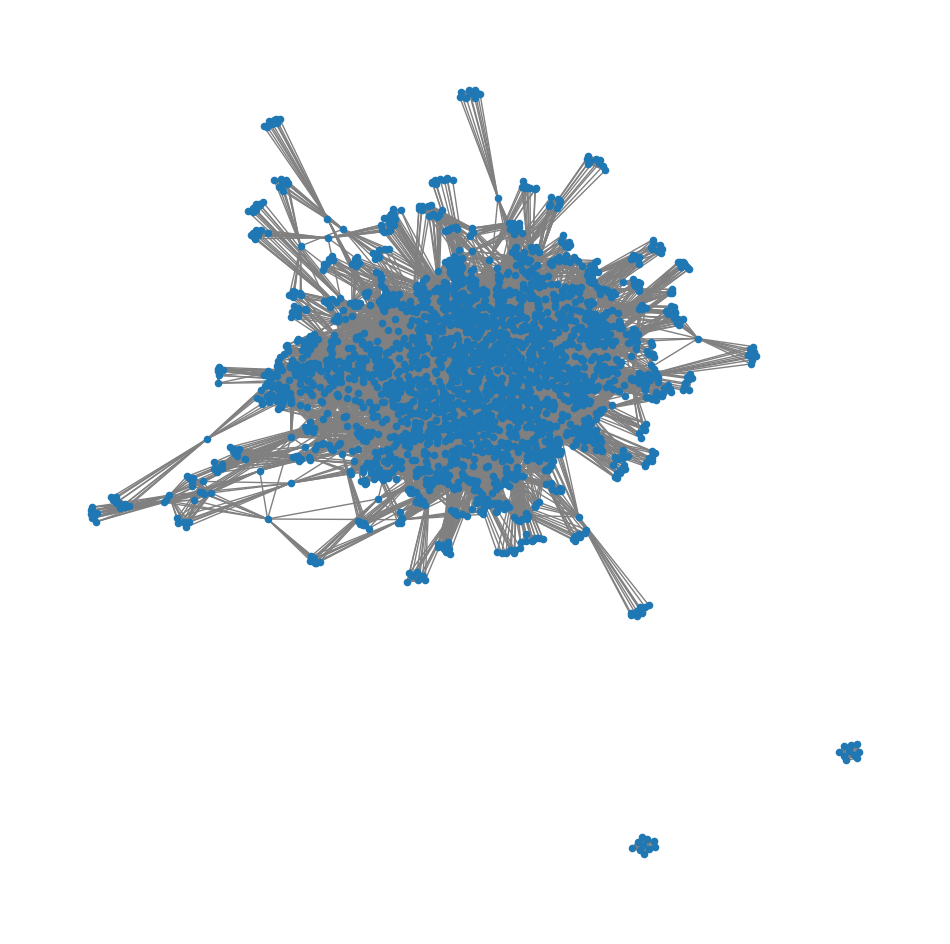

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx(G, pos, with_labels=False, node_size=20, edge_color='gray')
plt.axis('off')
plt.show()

Можно отфильтровать вершины графа, оставив только те, у кого, больше связей, чтобы взглянуть на самые популярные слова

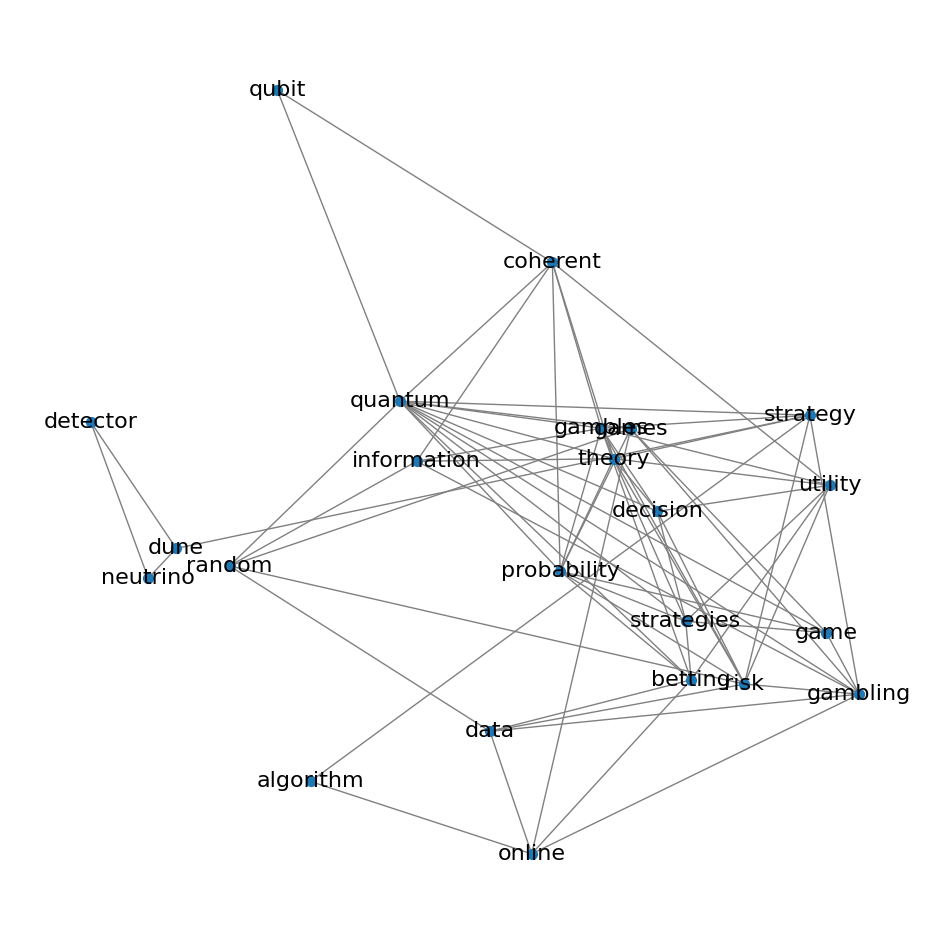

In [26]:
MIN_DEGREE = 80

nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree > MIN_DEGREE]
subG = G.subgraph(nodes_to_keep).copy()

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx(subG, pos, with_labels=True, font_size=16, node_size=50, edge_color='gray')
plt.axis('off')
plt.show()

## Оценка качества кластеризации

Используем алгоритм Louvain для выделения кластеров и анализа модулярности

In [32]:
clusters = nx.community.louvain_communities(G)
modularity = nx.community.modularity(G, clusters)
print(f'Number of clusters: {len(clusters)}, Modularity: {modularity}')

Number of clusters: 25, Modularity: 0.6418473468504289


На ~2500 узлов получилось 25 кластера, модулярность довольно высокая (чем ближе к 1 тем лучше - тем более выражены кластеры). Это может говорить о том, что данные охватывают много тематик/подтем и эти тематические блоки хорошо различимы

## Поиск ключевых слов

Найдем топ N ключевых слов по каждой мере:
- degree centrality - популярность узла, (его степень)
- betweenness centrality - узлы, которые связывают между собой кластера
- eigenvector centrality - ключевые узлы для тематики, т.е. узлы у которых много связей с другими важными узлами
- closeness centrality - насколько близко узел ко всем остальным, то есть универсальность

In [8]:
import pandas as pd

CENTRALITY_N = 5

def eval_centrality(graph, func, name, n=CENTRALITY_N):
    centrality = func(graph)
    top = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:n]
    df = pd.DataFrame(top, columns=['feature', name])
    print(df.to_string(index=False))
    print()
    return top

In [9]:
degree_top = eval_centrality(G, nx.degree_centrality, 'degree_centrality')
betweenness_top = eval_centrality(G, nx.betweenness_centrality, 'betweenness_centrality')
eigenvector_top = eval_centrality(G, nx.eigenvector_centrality, 'eigenvector_centrality')
closeness_top = eval_centrality(G, nx.closeness_centrality, 'closeness_centrality')

 feature  degree_centrality
 quantum           0.078104
    risk           0.042056
neutrino           0.032043
    dune           0.029372
detector           0.028037

feature  betweenness_centrality
quantum                0.278068
   risk                0.104126
betting                0.097029
   game                0.074425
gambles                0.056914

  feature  eigenvector_centrality
  quantum                0.570437
  betting                0.132789
      dot                0.128564
    qubit                0.128212
mechanics                0.113592

   feature  closeness_centrality
   quantum              0.294198
   betting              0.268685
   gambles              0.261193
strategies              0.256188
      game              0.255253



По результатам видно, что есть явная смесь двух тем - квантовая физика и теория вероятности,

## Построение графа публикаций

Будем ориентироваться на найденные в начале ключевые слова для каждой статьи

In [ ]:
from itertools import combinations
import networkx as nx

A = nx.Graph()

for i, j in combinations(range(len(articles_keywords)), 2):
    intersect = set(articles_keywords[i]).intersection(set(articles_keywords[j]))
    A.add_edge(i, j, weight=len(intersect))

Теперь напишем функцию для поиска ближайших соседей. Искать будет по принципу кратчайшего пути - то есть ближайшие статьи это те, до кототорых путь короче.

Чтобы учесть веса связей, будем искать кратчайшие пути по обратному весу, то есть чем больше вес -> тем меньше обратная величина -> тем ближе узел

In [46]:
for u, v, d in A.edges(data=True):
    if d["weight"] == 0:
        d["inv_weight"] = 100000
    else:
        d["inv_weight"] = 1. / d["weight"]

def find_closest_articles(target_index, top_n=10):
    lengths = nx.single_source_dijkstra_path_length(A, target_index, weight='inv_weight')
    closest = [(idx, dist) for idx, dist in lengths.items() if idx != target_index]
    closest.sort(key=lambda x: x[1])
    return closest[:top_n]

def print_closest(closest):
    print("Ближайшие статьи:")
    for i, (idx, dist) in enumerate(closest):
        print(f'{i + 1}. {articles[idx]["title"]} (dist={dist:.2f})')

In [47]:
TARGET_ARTICLE = 0

print(f'Целевая статья: {articles[TARGET_ARTICLE]["title"]}')

closest = find_closest_articles(TARGET_ARTICLE)
print_closest(closest)

Целевая статья: Automatic detection of problem-gambling signs from online texts using
  large language models
Ближайшие статьи:
1. Synthetic Data Generation for Fraud Detection using GANs (dist=0.50)
2. Online Gambling of Pure Chance: Wager Distribution, Risk Attitude, and
  Anomalous Diffusion (dist=0.50)
3. Multimodal Generative AI and Foundation Models for Behavioural Health in
  Online Gambling (dist=0.50)
4. Generative Adversarial Networks for Bitcoin Data Augmentation (dist=0.83)
5. Understanding Gambling Behavior and Risk Attitudes Using
  Cryptocurrency-based Casino Blockchain Data (dist=1.00)
6. Effects of Mobile Gacha Games on Gambling Behavior and Psychological
  Health (dist=1.00)
7. Mitigating Gambling-Like Risk-Taking Behaviors in Large Language Models:
  A Behavioral Economics Approach to AI Safety (dist=1.00)
8. Who is Gambling? Finding Cryptocurrency Gamblers Using Multi-modal
  Retrieval Methods (dist=1.00)
9. Quantum gambling using mesoscopic ring qubits (dist=1.00)
